### Question 2

https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/dataset/images/color/124084.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

481 321


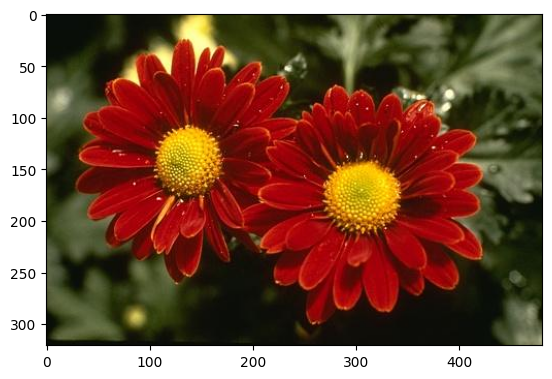

In [3]:
# import image
filename = "Pic1.jpg"
img = Image.open(filename)

# get image size
width, height = img.size
print(width, height)

# show the image
plt.imshow(img)
plt.show()

In [4]:
# convert to numpy array
img_np = np.asarray(img)
print(img_np.shape) # (H, W, RGB), dtype uint8

H, W, _ = img_np.shape

(321, 481, 3)


In [5]:
# Create feature vector (5-dimensions)
rows = np.arange(H)
cols = np.arange(W)
col_grid, row_grid = np.meshgrid(cols, rows)
print(col_grid.shape, row_grid.shape)

# Unroll
row_feat = row_grid.reshape(-1, 1)
col_feat = col_grid.reshape(-1, 1)
rgb = img_np.reshape(-1, 3).astype(np.float64) # 
print(row_feat.shape, col_feat.shape, rgb.shape)

X_raw = np.hstack([row_feat, col_feat, rgb]) # get shape (N, 5)
print(X_raw)

(321, 481) (321, 481)
(154401, 1) (154401, 1) (154401, 3)
[[  0.   0.   9.  14.  10.]
 [  0.   1.   9.  14.  10.]
 [  0.   2.   9.  14.  10.]
 ...
 [320. 478. 144. 148. 113.]
 [320. 479. 147. 149. 112.]
 [320. 480. 157. 157. 119.]]


In [14]:
# Normalize to [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_raw)
print(X.shape)

(154401, 5)


In [13]:
k_values = [i for i in range(1, 11)]
n_folds = 5
avg_scores = []
best_k = 0
best_score = -np.inf

# Loop over k values for model selection
for k in k_values:
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_scores_temp = []
    
    # Loop over each fold
    for train_index, val_index in kf.split(X):
        # Split data
        X_train = X[train_index]
        X_val = X[val_index]
        
        # Create GMM and fit it
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        gmm.fit(X_train)
        
        # Get score (log-likelihood) on validation set
        score = gmm.score(X_val)
        fold_scores_temp.append(score)
    
    # Calculate average for this K
    mean_score = np.mean(fold_scores_temp)
    avg_scores.append(mean_score)
    
    print(f"For K = {k}: avg val Log-Likelihood = {mean_score:.4f}")
    
    # Check if this is the best one
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"\nBest K found: {best_k}")


For K = 1: avg val Log-Likelihood = 1.0641
For K = 2: avg val Log-Likelihood = 2.2149
For K = 3: avg val Log-Likelihood = 2.9124
For K = 4: avg val Log-Likelihood = 3.4175
For K = 5: avg val Log-Likelihood = 4.0787
For K = 6: avg val Log-Likelihood = 4.0505
For K = 7: avg val Log-Likelihood = 4.4807
For K = 8: avg val Log-Likelihood = 4.4866
For K = 9: avg val Log-Likelihood = 4.5418
For K = 10: avg val Log-Likelihood = 4.6813

Best K found: 10


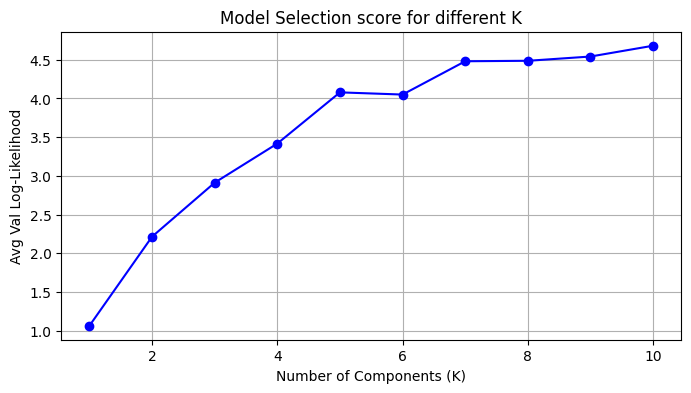

Training final GMM on all pixels with K=10...


In [15]:
plt.figure(figsize=(8, 4))

plt.plot(k_values, avg_scores, marker='o', linestyle='-', color='b')
plt.title("Model Selection score for different K")
plt.xlabel("Number of Components (K)")
plt.ylabel("Avg Val Log-Likelihood")
plt.grid(True)
plt.show()

print(f"Training final GMM on all pixels with K={best_k}...")

In [9]:
# Retrain using k values from model selection (look at plot to figure out which k to use)
final_gmm_1 = GaussianMixture(n_components=2, covariance_type='full', random_state=10)
final_gmm_1.fit(X)

labels = final_gmm_1.predict(X)
Output_pic = labels.reshape(H, W) # convert back to (H, W)
print(labels.shape)
print(Output_pic.shape)

(154401,)
(321, 481)


In [10]:
final_gmm_2 = GaussianMixture(n_components=5, covariance_type='full', random_state=10)
final_gmm_2.fit(X)

labels = final_gmm_2.predict(X)
Output_pic_2 = labels.reshape(H, W)

In [11]:
final_gmm_3 = GaussianMixture(n_components=10, covariance_type='full', random_state=10)
final_gmm_3.fit(X)

labels = final_gmm_3.predict(X)
Output_pic_3 = labels.reshape(H, W)

### Visualization

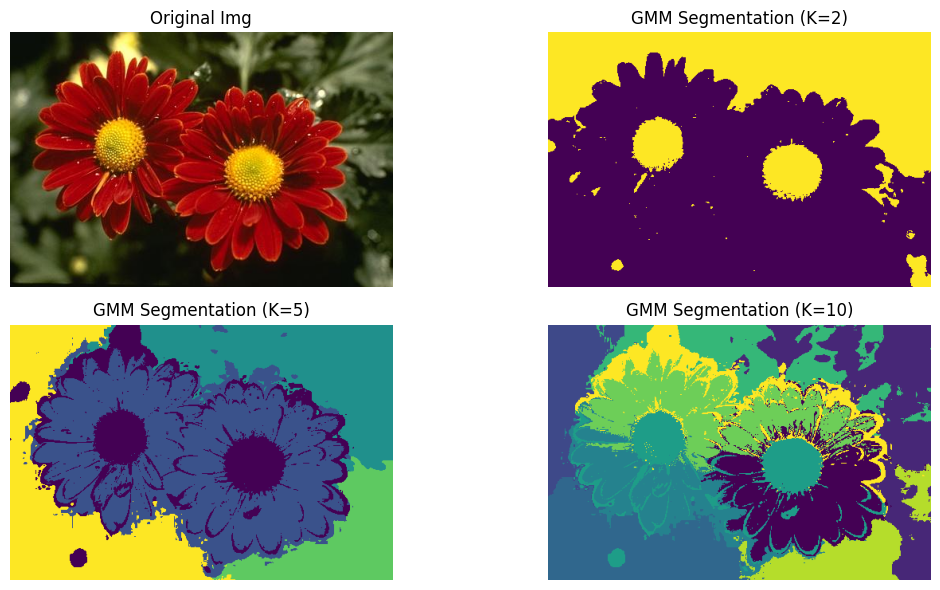

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1) # 2 row, 2 columns, plot 1
plt.imshow(img) # Use the original PIL image or img_np
plt.title("Original Img")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(Output_pic) # cmap = 'gray' if require grayscale
plt.title(f"GMM Segmentation (K=2)")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(Output_pic_2)
plt.title(f"GMM Segmentation (K=5)")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(Output_pic_3)
plt.title(f"GMM Segmentation (K=10)")
plt.axis('off')

plt.tight_layout()
plt.show()